## Question 1
### (10 points) Using Kim’s video and reading material set the output you want to |10>. Show your Python code and a screen capture of the results.

In [ ]:
# General
import numpy as np

# Plotting routines
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Qiskit Aer imports
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler, SamplerOptions

from qiskit.compiler import transpile, assemble
from qiskit.transpiler import PassManager, CouplingMap

from qiskit.circuit.library import GroverOperator

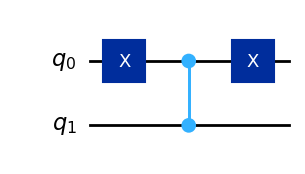

In [3]:
# Step 1: Define the Oracle circuit
oracle = QuantumCircuit(2, name="oracle")

# Step 2: Apply an X gate to qubit 1 to swap |10⟩ <-> |11⟩
oracle.x(0)

# Step 3: Apply a Controlled-Z (CZ) Gate (flips phase of |11⟩, which was originally |10⟩)
oracle.cz(0, 1)

# Step 4: Apply another X gate to revert the transformation
oracle.x(0)

# Step 5: Convert to gate (optional, for modularity)
oracle_gate = oracle.to_gate()

# Step 6: Draw the Oracle circuit
oracle.draw("mpl")

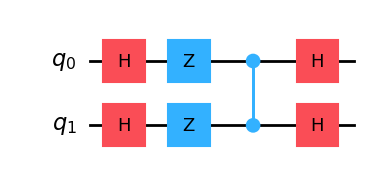

In [4]:
reflection = QuantumCircuit(2, name="reflection")
reflection.h([0,1])
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1])
reflection.to_gate()
reflection.draw("mpl")

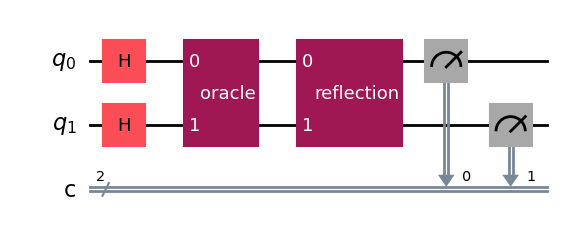

In [5]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle,[0,1])
grover_circ.append(reflection,[0,1])
grover_circ.measure([0,1],[0,1])
grover_circ.draw('mpl')

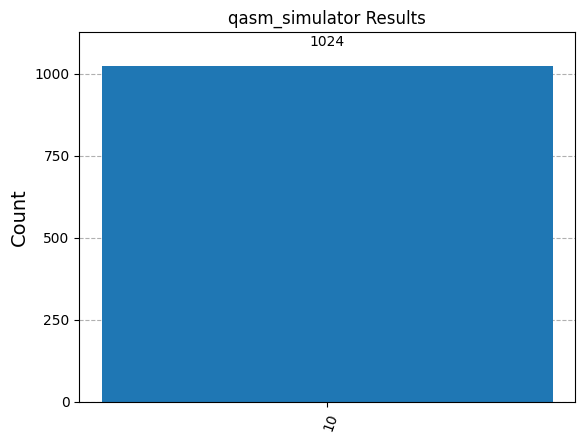

In [6]:
backend = Aer.get_backend("qasm_simulator")
# Simulate the circuit
t_qc = transpile(grover_circ, backend)
# print(t_qc)
result = backend.run(t_qc).result()
# print(result)

counts = result.get_counts()

# plot the results
from qiskit.visualization import plot_histogram
plot_histogram(counts, title="qasm_simulator Results")

## Question 2
### (10 points) Do the same experiment as above (3 qubit looking for ket |101>) but on a real backend and use 1000 shots. Again, show your Python code and screen capture of the results. Everyone should have different results for this, so don’t copy your friends.

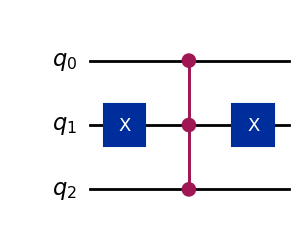

In [ ]:
# Step 1: Define the Oracle circuit for |101⟩
oracle = QuantumCircuit(3, name="oracle")  # 3-qubit circuit

# Step 2: Apply X gates to qubits 0 and 2
# This transforms |101⟩ into |111⟩ so that we can apply a CCZ gate.
oracle.x(1)
# oracle.x(2)

# Step 3: Apply a Controlled-Controlled-Z (CCZ) gate
# This flips the phase of |111⟩ (originally |101⟩)
oracle.ccz(0, 1, 2)

# Step 4: Undo the X gates to restore original basis
oracle.x(1)
# oracle.x(2)

# Step 5: Convert to a gate (optional, for modularity)
#oracle_gate = oracle.to_gate()

# Step 6: Draw the Oracle Circuit
oracle.draw("mpl")

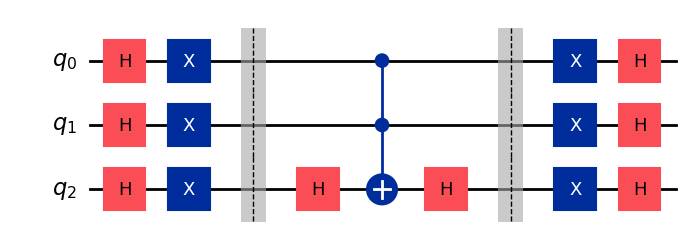

In [4]:
# Step 1: Define the 3-qubit reflection circuit
diffusion = QuantumCircuit(3, name="diffusion")

# Step 2: Apply Hadamard gates to all qubits
diffusion.h([0,1,2])

diffusion.x([0, 1, 2])

diffusion.barrier()

diffusion.h(2)
diffusion.ccx(0, 1, 2)
diffusion.h(2)

diffusion.barrier()

diffusion.x([0, 1, 2])

# Step 5: Apply Hadamard gates again
diffusion.h([0,1,2])

# Step 6: Convert to a gate (for modular use)
# diffusion_gate = diffusion_gate.to_gate()

# Step 7: Draw the Reflection circuit
diffusion.draw("mpl")

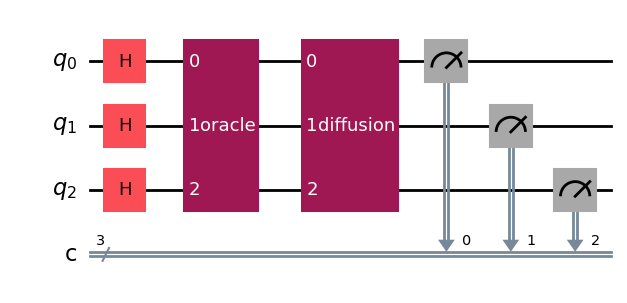

In [5]:
grover_circ = QuantumCircuit(3,3)
grover_circ.h([0,1,2])
grover_circ.append(oracle,[0,1,2])
grover_circ.append(diffusion,[0,1,2])
grover_circ.measure([0,1,2],[0,1,2])
grover_circ.draw('mpl')

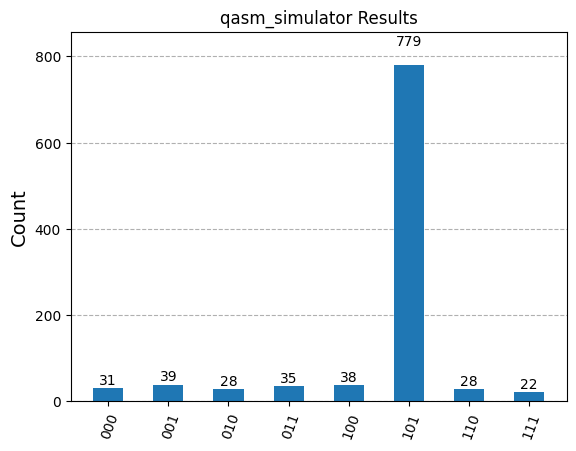

In [6]:
backend = Aer.get_backend("qasm_simulator")
# Simulate the circuit
t_qc = transpile(grover_circ, backend)
# print(t_qc)
result = backend.run(t_qc, shots=1000).result()
# print(result)

counts = result.get_counts()

# plot the results
plot_histogram(counts, title="qasm_simulator Results")

In [7]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="9199b5043381bf71eda4b90f02290e9ad349e1467946d68e8d8ae3e1daa35386930d13b21d73403c7b7dc8cd7c8875f648b90cb4e6f1843383edb9bb2c5dde29",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

In [8]:
# Load saved credentials
service = QiskitRuntimeService()

In [19]:
import webbrowser
webbrowser.open(f"https://quantum.ibm.com/services/resources?system={backend.name}")

True

In [9]:
print(service.backends())
backend = service.backend('ibm_brisbane')

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [10]:
noise_model = NoiseModel.from_backend(backend)
noisy_simulator = AerSimulator(noise_model=noise_model)

In [11]:
# Assuming you have a backend reference and a circuit
transpiled_circuit = transpile(grover_circ, backend, optimization_level=3)

{'011': 43, '111': 40, '110': 35, '100': 51, '001': 53, '000': 36, '010': 43, '101': 699}


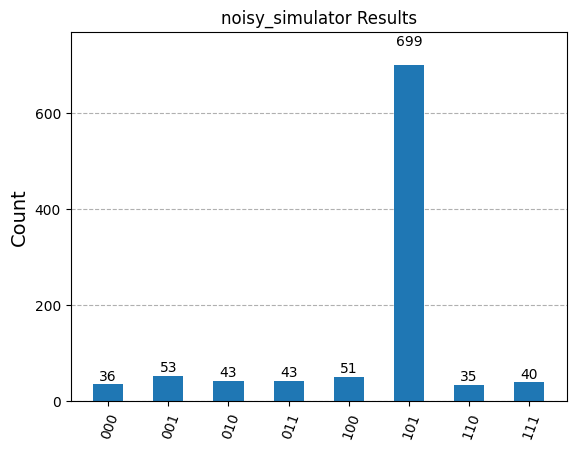

In [12]:
# Run the transpiled circuits on the noisy simulator
job = noisy_simulator.run(transpiled_circuit, shots=1000)
result = job.result()

# Plot the results
counts = result.get_counts(0)
print(counts)
plot_histogram(counts, title="noisy_simulator Results")

In [13]:
pass_manager = generate_preset_pass_manager(
    optimization_level=2,  # Adjust the level as needed (0-3)
    backend=backend
)
print(pass_manager)
transpiled_circuit = pass_manager.run(grover_circ)
print(transpiled_circuit.depth())
num_qubits = transpiled_circuit.num_qubits
print(num_qubits)

86
127


In [14]:
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit]) # Wrap circuit in a list

job_id = job.job_id()

print(f"Job ID: {job_id}")

Job ID: czm31wzp3xeg008h98pg


In [33]:
job.status()

'DONE'

BitArray(<shape=(), num_shots=4096, num_bits=3>)


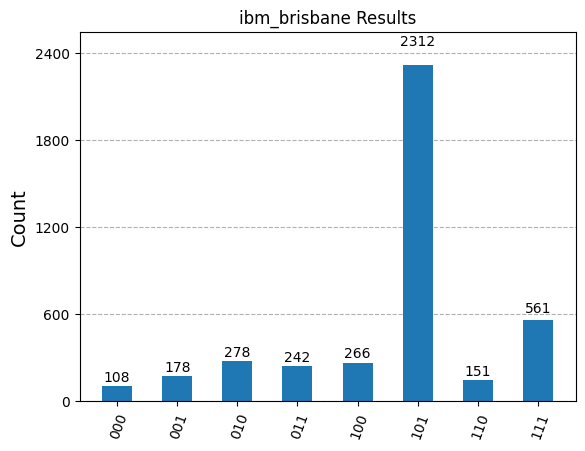

In [38]:
result = job.result()[0].data.c
print(result)
# Plot the results
counts = result.get_counts()
plot_histogram(counts, title="ibm_brisbane Results")

## Question 3
### (10 points) Now use Grover’s Algorithm to solve a 3-SAT problem for the following DIMACS Conjunctive Normal Form (CNF). Read in CNF file, use PhaseOracle in QISKIT to build this as an Oracle. Then use Grover’s algorithm on real quantum computer to solve.

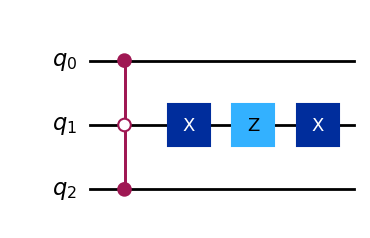

In [40]:
from qiskit.circuit.library import ZGate

oracle = QuantumCircuit(3)
U1 = ZGate().control(num_ctrl_qubits = 2, ctrl_state = '01')
oracle.append(U1,qargs = [0,1,2])

oracle.x(1)   # Apply X gate
oracle.z(1)   # Apply Z gate
oracle.x(1)   # Apply X gate

oracle.draw('mpl')

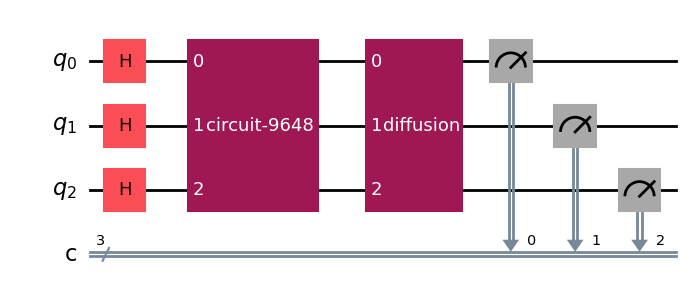

In [41]:
grover_circ = QuantumCircuit(3,3)
grover_circ.h([0,1,2])
grover_circ.append(oracle,[0,1,2])
grover_circ.append(diffusion,[0,1,2])
grover_circ.measure([0,1,2],[0,1,2])
grover_circ.draw('mpl')

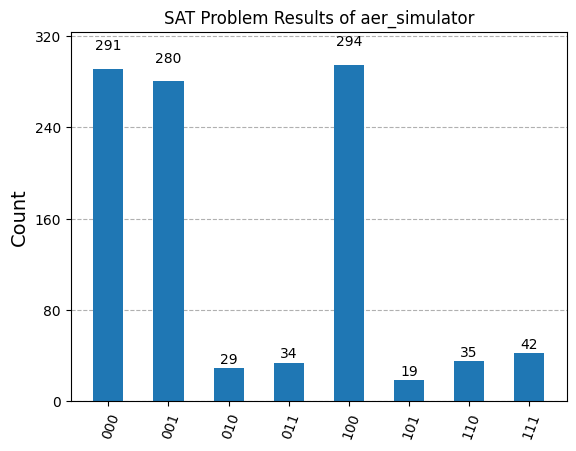

In [42]:
# Step 7: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 8: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="SAT Problem Results of aer_simulator")

In [43]:
pass_manager = generate_preset_pass_manager(
    optimization_level=2,  # Adjust the level as needed (0-3)
    backend=backend
)
print(pass_manager)
transpiled_circuit = pass_manager.run(grover_circ)
print(transpiled_circuit.depth())
num_qubits = transpiled_circuit.num_qubits
print(num_qubits)

8
3


In [44]:
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit]) # Wrap circuit in a list

job_id = job.job_id()

print(f"Job ID: {job_id}")

Job ID: df7f1ad6-dedf-4ff9-82f3-fad3e6b1abb4


In [46]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

BitArray(<shape=(), num_shots=1024, num_bits=3>)


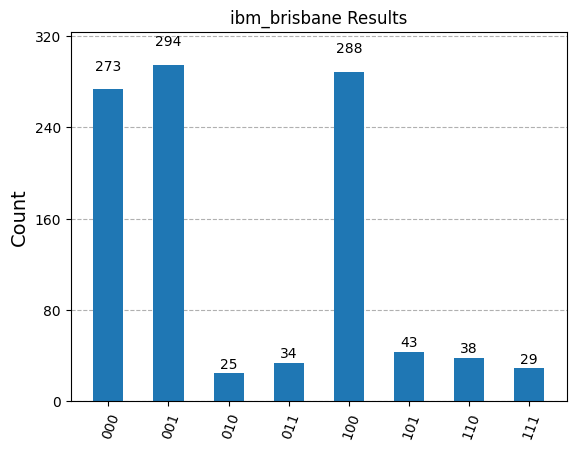

In [49]:
result = job.result()[0].data.c
print(result)
# Plot the results
counts = result.get_counts()
plot_histogram(counts, title="ibm_brisbane Results")